In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='50-5d'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs/profiles-v1/profiles-v1-pca-5d'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
INPUT_PT_PATH = f"/workspace/datasets/profiles-v1/profiles-v1-pca-5d/profiles-v1-pca-5-sample-{EXPERIMENT_NUM}.pt"
LABEL = f'profiles_v1_pca_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_50-5d_20250802_2053


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_50-5d_20250802_2053/density_plot.png


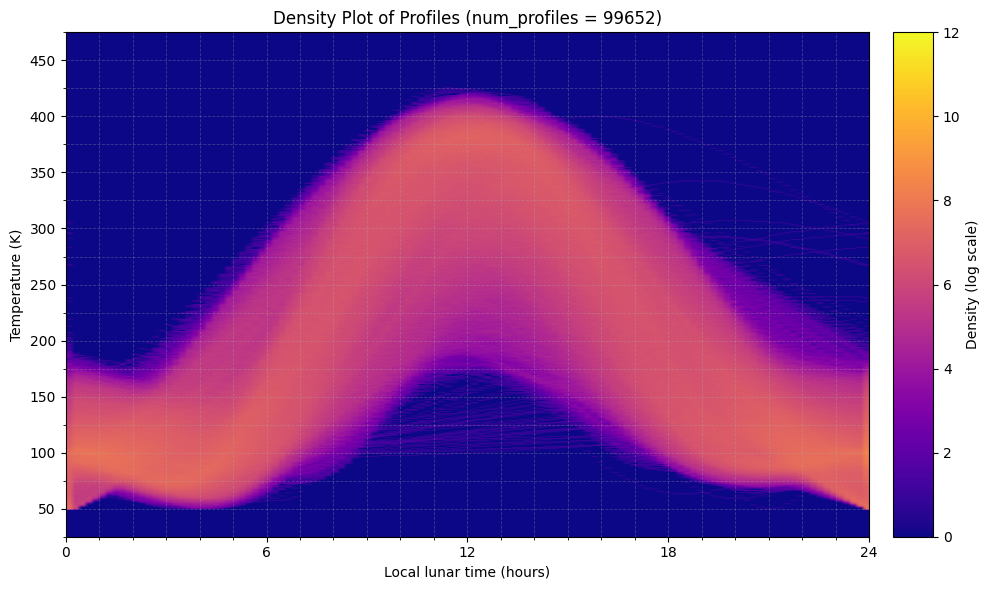

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 196.6888
STD: 96.7905
Min Temp: 50.0000
Max Temp: 424.9460
Datasets:
Training Data: 69756
Validation Data: 19930
Test Data: 9966


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 349/349 [00:11<00:00, 29.72it/s, best_loss=0.6708]


[Training] Epoch 1/100, L1 Loss: 0.6769, L2 Loss: 0.7336, KL Loss: 0.4137, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 100/100 [00:00<00:00, 105.84it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5782, Val L2 Loss: 0.5884, Val KL Loss: 0.5846
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_50-5d_20250802_2053'


[Training] Epoch 2/100: 100%|██████████| 349/349 [00:11<00:00, 29.63it/s, best_loss=0.6226]


[Training] Epoch 2/100, L1 Loss: 0.6124, L2 Loss: 0.6283, KL Loss: 0.5714, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 100/100 [00:00<00:00, 106.64it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.5745, Val L2 Loss: 0.5841, Val KL Loss: 0.5753
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_50-5d_20250802_2053'


[Training] Epoch 3/100: 100%|██████████| 349/349 [00:11<00:00, 29.67it/s, best_loss=0.6369]


[Training] Epoch 3/100, L1 Loss: 0.6105, L2 Loss: 0.6258, KL Loss: 0.5795, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 100/100 [00:00<00:00, 106.20it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.5776, Val L2 Loss: 0.5866, Val KL Loss: 0.5661


[Training] Epoch 4/100: 100%|██████████| 349/349 [00:11<00:00, 29.88it/s, best_loss=0.6446]


[Training] Epoch 4/100, L1 Loss: 0.6101, L2 Loss: 0.6254, KL Loss: 0.5791, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 100/100 [00:01<00:00, 96.10it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5741, Val L2 Loss: 0.5833, Val KL Loss: 0.5759
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_50-5d_20250802_2053'


[Training] Epoch 5/100: 100%|██████████| 349/349 [00:11<00:00, 29.18it/s, best_loss=0.6413]


[Training] Epoch 5/100, L1 Loss: 0.6101, L2 Loss: 0.6255, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 100/100 [00:00<00:00, 104.46it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.5727, Val L2 Loss: 0.5826, Val KL Loss: 0.5794
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_50-5d_20250802_2053'


[Training] Epoch 6/100: 100%|██████████| 349/349 [00:11<00:00, 30.38it/s, best_loss=0.6408]


[Training] Epoch 6/100, L1 Loss: 0.6099, L2 Loss: 0.6253, KL Loss: 0.5792, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 100/100 [00:00<00:00, 107.81it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5713, Val L2 Loss: 0.5813, Val KL Loss: 0.5851
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_50-5d_20250802_2053'


[Training] Epoch 7/100: 100%|██████████| 349/349 [00:11<00:00, 30.18it/s, best_loss=0.6452]


[Training] Epoch 7/100, L1 Loss: 0.6100, L2 Loss: 0.6252, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 100/100 [00:01<00:00, 98.19it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5736, Val L2 Loss: 0.5830, Val KL Loss: 0.5751


[Training] Epoch 8/100: 100%|██████████| 349/349 [00:11<00:00, 29.52it/s, best_loss=0.6516]


[Training] Epoch 8/100, L1 Loss: 0.6094, L2 Loss: 0.6244, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 100/100 [00:00<00:00, 104.33it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5739, Val L2 Loss: 0.5834, Val KL Loss: 0.5813


[Training] Epoch 9/100: 100%|██████████| 349/349 [00:11<00:00, 29.85it/s, best_loss=0.6477]


[Training] Epoch 9/100, L1 Loss: 0.6098, L2 Loss: 0.6249, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 100/100 [00:00<00:00, 105.09it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5744, Val L2 Loss: 0.5835, Val KL Loss: 0.5761


[Training] Epoch 10/100: 100%|██████████| 349/349 [00:11<00:00, 29.72it/s, best_loss=0.6361]


[Training] Epoch 10/100, L1 Loss: 0.6102, L2 Loss: 0.6253, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 100/100 [00:00<00:00, 105.20it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5808, Val L2 Loss: 0.5892, Val KL Loss: 0.5644


[Training] Epoch 11/100: 100%|██████████| 349/349 [00:11<00:00, 29.93it/s, best_loss=0.6209]


[Training] Epoch 11/100, L1 Loss: 0.6100, L2 Loss: 0.6255, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 100/100 [00:00<00:00, 105.69it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5759, Val L2 Loss: 0.5848, Val KL Loss: 0.5748


[Training] Epoch 12/100: 100%|██████████| 349/349 [00:11<00:00, 29.99it/s, best_loss=0.6373]


[Training] Epoch 12/100, L1 Loss: 0.6102, L2 Loss: 0.6253, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 100/100 [00:01<00:00, 98.72it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5757, Val L2 Loss: 0.5847, Val KL Loss: 0.5726


[Training] Epoch 13/100: 100%|██████████| 349/349 [00:11<00:00, 29.25it/s, best_loss=0.6489]


[Training] Epoch 13/100, L1 Loss: 0.6097, L2 Loss: 0.6247, KL Loss: 0.5792, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 100/100 [00:01<00:00, 85.43it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.5744, Val L2 Loss: 0.5838, Val KL Loss: 0.5731


[Training] Epoch 14/100: 100%|██████████| 349/349 [00:12<00:00, 28.99it/s, best_loss=0.6481]


[Training] Epoch 14/100, L1 Loss: 0.6102, L2 Loss: 0.6255, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 100/100 [00:00<00:00, 102.31it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5728, Val L2 Loss: 0.5824, Val KL Loss: 0.5810


[Training] Epoch 15/100: 100%|██████████| 349/349 [00:11<00:00, 29.80it/s, best_loss=0.6610]


[Training] Epoch 15/100, L1 Loss: 0.6097, L2 Loss: 0.6248, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 100/100 [00:01<00:00, 96.64it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5766, Val L2 Loss: 0.5855, Val KL Loss: 0.5738


[Training] Epoch 16/100: 100%|██████████| 349/349 [00:11<00:00, 29.85it/s, best_loss=0.6359]


[Training] Epoch 16/100, L1 Loss: 0.6102, L2 Loss: 0.6253, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 100/100 [00:00<00:00, 102.86it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5746, Val L2 Loss: 0.5838, Val KL Loss: 0.5760


[Training] Epoch 17/100: 100%|██████████| 349/349 [00:11<00:00, 29.68it/s, best_loss=0.6461]


[Training] Epoch 17/100, L1 Loss: 0.6100, L2 Loss: 0.6253, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 100/100 [00:00<00:00, 102.91it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5736, Val L2 Loss: 0.5835, Val KL Loss: 0.5759


[Training] Epoch 18/100: 100%|██████████| 349/349 [00:11<00:00, 29.77it/s, best_loss=0.6557]


[Training] Epoch 18/100, L1 Loss: 0.6100, L2 Loss: 0.6253, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 100/100 [00:01<00:00, 98.33it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5732, Val L2 Loss: 0.5824, Val KL Loss: 0.5812


[Training] Epoch 19/100: 100%|██████████| 349/349 [00:11<00:00, 29.41it/s, best_loss=0.6419]


[Training] Epoch 19/100, L1 Loss: 0.6097, L2 Loss: 0.6248, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 100/100 [00:01<00:00, 95.40it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5750, Val L2 Loss: 0.5839, Val KL Loss: 0.5753


[Training] Epoch 20/100: 100%|██████████| 349/349 [00:11<00:00, 30.13it/s, best_loss=0.6351]


[Training] Epoch 20/100, L1 Loss: 0.6100, L2 Loss: 0.6250, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 100/100 [00:00<00:00, 100.07it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5745, Val L2 Loss: 0.5835, Val KL Loss: 0.5723


[Training] Epoch 21/100: 100%|██████████| 349/349 [00:11<00:00, 29.75it/s, best_loss=0.6357]


[Training] Epoch 21/100, L1 Loss: 0.6098, L2 Loss: 0.6252, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 100/100 [00:00<00:00, 104.39it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5716, Val L2 Loss: 0.5814, Val KL Loss: 0.5804


[Training] Epoch 22/100: 100%|██████████| 349/349 [00:11<00:00, 29.74it/s, best_loss=0.6316]


[Training] Epoch 22/100, L1 Loss: 0.6099, L2 Loss: 0.6252, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 100/100 [00:01<00:00, 95.70it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5743, Val L2 Loss: 0.5837, Val KL Loss: 0.5733


[Training] Epoch 23/100: 100%|██████████| 349/349 [00:11<00:00, 29.96it/s, best_loss=0.6445]


[Training] Epoch 23/100, L1 Loss: 0.6102, L2 Loss: 0.6255, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 100/100 [00:00<00:00, 103.51it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5735, Val L2 Loss: 0.5831, Val KL Loss: 0.5756


[Training] Epoch 24/100: 100%|██████████| 349/349 [00:11<00:00, 29.58it/s, best_loss=0.6493]


[Training] Epoch 24/100, L1 Loss: 0.6098, L2 Loss: 0.6250, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 100/100 [00:00<00:00, 103.43it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5751, Val L2 Loss: 0.5843, Val KL Loss: 0.5753


[Training] Epoch 25/100: 100%|██████████| 349/349 [00:11<00:00, 29.50it/s, best_loss=0.6394]


[Training] Epoch 25/100, L1 Loss: 0.6097, L2 Loss: 0.6249, KL Loss: 0.5792, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 100/100 [00:01<00:00, 99.08it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5736, Val L2 Loss: 0.5830, Val KL Loss: 0.5759


[Training] Epoch 26/100: 100%|██████████| 349/349 [00:11<00:00, 29.60it/s, best_loss=0.6318]


[Training] Epoch 26/100, L1 Loss: 0.6096, L2 Loss: 0.6244, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 100/100 [00:00<00:00, 102.64it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5733, Val L2 Loss: 0.5826, Val KL Loss: 0.5770


[Training] Epoch 27/100: 100%|██████████| 349/349 [00:11<00:00, 29.70it/s, best_loss=0.6489]


[Training] Epoch 27/100, L1 Loss: 0.6096, L2 Loss: 0.6247, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 100/100 [00:00<00:00, 101.73it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5731, Val L2 Loss: 0.5826, Val KL Loss: 0.5787


[Training] Epoch 28/100: 100%|██████████| 349/349 [00:11<00:00, 29.36it/s, best_loss=0.6442]


[Training] Epoch 28/100, L1 Loss: 0.6098, L2 Loss: 0.6250, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 100/100 [00:01<00:00, 98.61it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5758, Val L2 Loss: 0.5849, Val KL Loss: 0.5712


[Training] Epoch 29/100: 100%|██████████| 349/349 [00:11<00:00, 29.40it/s, best_loss=0.6248]


[Training] Epoch 29/100, L1 Loss: 0.6103, L2 Loss: 0.6256, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 100/100 [00:00<00:00, 100.17it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5737, Val L2 Loss: 0.5831, Val KL Loss: 0.5791


[Training] Epoch 30/100: 100%|██████████| 349/349 [00:11<00:00, 29.60it/s, best_loss=0.6328]


[Training] Epoch 30/100, L1 Loss: 0.6100, L2 Loss: 0.6250, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 100/100 [00:00<00:00, 103.12it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5755, Val L2 Loss: 0.5845, Val KL Loss: 0.5702


[Training] Epoch 31/100: 100%|██████████| 349/349 [00:11<00:00, 29.63it/s, best_loss=0.6387]


[Training] Epoch 31/100, L1 Loss: 0.6104, L2 Loss: 0.6256, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 100/100 [00:01<00:00, 99.58it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5715, Val L2 Loss: 0.5815, Val KL Loss: 0.5797


[Training] Epoch 32/100: 100%|██████████| 349/349 [00:11<00:00, 29.97it/s, best_loss=0.6515]


[Training] Epoch 32/100, L1 Loss: 0.6099, L2 Loss: 0.6250, KL Loss: 0.5792, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 100/100 [00:00<00:00, 103.62it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5751, Val L2 Loss: 0.5843, Val KL Loss: 0.5759


[Training] Epoch 33/100: 100%|██████████| 349/349 [00:11<00:00, 29.47it/s, best_loss=0.6565]


[Training] Epoch 33/100, L1 Loss: 0.6102, L2 Loss: 0.6258, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 100/100 [00:01<00:00, 93.42it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5714, Val L2 Loss: 0.5810, Val KL Loss: 0.5868


[Training] Epoch 34/100: 100%|██████████| 349/349 [00:11<00:00, 29.39it/s, best_loss=0.6329]


[Training] Epoch 34/100, L1 Loss: 0.6098, L2 Loss: 0.6251, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 100/100 [00:00<00:00, 107.43it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5734, Val L2 Loss: 0.5828, Val KL Loss: 0.5762


[Training] Epoch 35/100: 100%|██████████| 349/349 [00:11<00:00, 30.04it/s, best_loss=0.6419]


[Training] Epoch 35/100, L1 Loss: 0.6098, L2 Loss: 0.6249, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 100/100 [00:01<00:00, 97.93it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5734, Val L2 Loss: 0.5828, Val KL Loss: 0.5790


[Training] Epoch 36/100: 100%|██████████| 349/349 [00:11<00:00, 29.66it/s, best_loss=0.6493]


[Training] Epoch 36/100, L1 Loss: 0.6102, L2 Loss: 0.6255, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 100/100 [00:00<00:00, 105.29it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5734, Val L2 Loss: 0.5827, Val KL Loss: 0.5767


[Training] Epoch 37/100: 100%|██████████| 349/349 [00:11<00:00, 29.54it/s, best_loss=0.6196]


[Training] Epoch 37/100, L1 Loss: 0.6100, L2 Loss: 0.6254, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 100/100 [00:00<00:00, 106.92it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5727, Val L2 Loss: 0.5819, Val KL Loss: 0.5817


[Training] Epoch 38/100: 100%|██████████| 349/349 [00:11<00:00, 29.92it/s, best_loss=0.6313]


[Training] Epoch 38/100, L1 Loss: 0.6094, L2 Loss: 0.6246, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 100/100 [00:00<00:00, 101.62it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5739, Val L2 Loss: 0.5833, Val KL Loss: 0.5756


[Training] Epoch 39/100: 100%|██████████| 349/349 [00:11<00:00, 29.47it/s, best_loss=0.6342]


[Training] Epoch 39/100, L1 Loss: 0.6102, L2 Loss: 0.6254, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 100/100 [00:00<00:00, 104.10it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5765, Val L2 Loss: 0.5852, Val KL Loss: 0.5722


[Training] Epoch 40/100: 100%|██████████| 349/349 [00:11<00:00, 29.25it/s, best_loss=0.6214]


[Training] Epoch 40/100, L1 Loss: 0.6100, L2 Loss: 0.6253, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 100/100 [00:00<00:00, 103.35it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5703, Val L2 Loss: 0.5802, Val KL Loss: 0.5861
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_50-5d_20250802_2053'


[Training] Epoch 41/100: 100%|██████████| 349/349 [00:11<00:00, 29.52it/s, best_loss=0.6319]


[Training] Epoch 41/100, L1 Loss: 0.6102, L2 Loss: 0.6253, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 100/100 [00:01<00:00, 96.50it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5783, Val L2 Loss: 0.5865, Val KL Loss: 0.5680


[Training] Epoch 42/100: 100%|██████████| 349/349 [00:11<00:00, 29.64it/s, best_loss=0.6404]


[Training] Epoch 42/100, L1 Loss: 0.6097, L2 Loss: 0.6249, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 100/100 [00:00<00:00, 100.91it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5709, Val L2 Loss: 0.5807, Val KL Loss: 0.5808


[Training] Epoch 43/100: 100%|██████████| 349/349 [00:12<00:00, 28.98it/s, best_loss=0.6392]


[Training] Epoch 43/100, L1 Loss: 0.6104, L2 Loss: 0.6256, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 100/100 [00:01<00:00, 97.52it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5738, Val L2 Loss: 0.5832, Val KL Loss: 0.5775


[Training] Epoch 44/100: 100%|██████████| 349/349 [00:11<00:00, 29.46it/s, best_loss=0.6399]


[Training] Epoch 44/100, L1 Loss: 0.6099, L2 Loss: 0.6251, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 100/100 [00:00<00:00, 104.67it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5736, Val L2 Loss: 0.5828, Val KL Loss: 0.5777


[Training] Epoch 45/100: 100%|██████████| 349/349 [00:11<00:00, 29.92it/s, best_loss=0.6356]


[Training] Epoch 45/100, L1 Loss: 0.6098, L2 Loss: 0.6251, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 100/100 [00:00<00:00, 100.53it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5727, Val L2 Loss: 0.5823, Val KL Loss: 0.5776


[Training] Epoch 46/100: 100%|██████████| 349/349 [00:11<00:00, 29.62it/s, best_loss=0.6222]


[Training] Epoch 46/100, L1 Loss: 0.6098, L2 Loss: 0.6251, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 100/100 [00:00<00:00, 104.07it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5761, Val L2 Loss: 0.5850, Val KL Loss: 0.5722


[Training] Epoch 47/100: 100%|██████████| 349/349 [00:11<00:00, 29.80it/s, best_loss=0.6403]


[Training] Epoch 47/100, L1 Loss: 0.6096, L2 Loss: 0.6247, KL Loss: 0.5792, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 100/100 [00:01<00:00, 98.12it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5744, Val L2 Loss: 0.5837, Val KL Loss: 0.5782


[Training] Epoch 48/100: 100%|██████████| 349/349 [00:11<00:00, 29.23it/s, best_loss=0.6374]


[Training] Epoch 48/100, L1 Loss: 0.6100, L2 Loss: 0.6255, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 100/100 [00:01<00:00, 90.34it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5736, Val L2 Loss: 0.5832, Val KL Loss: 0.5737


[Training] Epoch 49/100: 100%|██████████| 349/349 [00:11<00:00, 29.39it/s, best_loss=0.6468]


[Training] Epoch 49/100, L1 Loss: 0.6102, L2 Loss: 0.6251, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 100/100 [00:00<00:00, 103.50it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5747, Val L2 Loss: 0.5840, Val KL Loss: 0.5719


[Training] Epoch 50/100: 100%|██████████| 349/349 [00:11<00:00, 29.89it/s, best_loss=0.6548]


[Training] Epoch 50/100, L1 Loss: 0.6100, L2 Loss: 0.6255, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 100/100 [00:00<00:00, 102.27it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5744, Val L2 Loss: 0.5836, Val KL Loss: 0.5832


[Training] Epoch 51/100: 100%|██████████| 349/349 [00:11<00:00, 29.57it/s, best_loss=0.6442]


[Training] Epoch 51/100, L1 Loss: 0.6095, L2 Loss: 0.6246, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 100/100 [00:00<00:00, 100.10it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.5737, Val L2 Loss: 0.5834, Val KL Loss: 0.5752


[Training] Epoch 52/100: 100%|██████████| 349/349 [00:11<00:00, 30.00it/s, best_loss=0.6404]


[Training] Epoch 52/100, L1 Loss: 0.6095, L2 Loss: 0.6245, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 100/100 [00:00<00:00, 104.92it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5740, Val L2 Loss: 0.5833, Val KL Loss: 0.5756


[Training] Epoch 53/100: 100%|██████████| 349/349 [00:11<00:00, 29.54it/s, best_loss=0.6505]


[Training] Epoch 53/100, L1 Loss: 0.6099, L2 Loss: 0.6250, KL Loss: 0.5792, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 100/100 [00:01<00:00, 92.52it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5734, Val L2 Loss: 0.5830, Val KL Loss: 0.5761


[Training] Epoch 54/100: 100%|██████████| 349/349 [00:11<00:00, 29.19it/s, best_loss=0.6426]


[Training] Epoch 54/100, L1 Loss: 0.6097, L2 Loss: 0.6249, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 100/100 [00:00<00:00, 107.13it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5742, Val L2 Loss: 0.5833, Val KL Loss: 0.5765


[Training] Epoch 55/100: 100%|██████████| 349/349 [00:11<00:00, 29.85it/s, best_loss=0.6317]


[Training] Epoch 55/100, L1 Loss: 0.6099, L2 Loss: 0.6250, KL Loss: 0.5792, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 100/100 [00:00<00:00, 109.13it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5730, Val L2 Loss: 0.5823, Val KL Loss: 0.5772


[Training] Epoch 56/100: 100%|██████████| 349/349 [00:11<00:00, 29.97it/s, best_loss=0.6355]


[Training] Epoch 56/100, L1 Loss: 0.6099, L2 Loss: 0.6252, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 100/100 [00:00<00:00, 101.21it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5735, Val L2 Loss: 0.5828, Val KL Loss: 0.5747


[Training] Epoch 57/100: 100%|██████████| 349/349 [00:11<00:00, 29.46it/s, best_loss=0.6347]


[Training] Epoch 57/100, L1 Loss: 0.6100, L2 Loss: 0.6254, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 100/100 [00:00<00:00, 100.47it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.5744, Val L2 Loss: 0.5836, Val KL Loss: 0.5744


[Training] Epoch 58/100: 100%|██████████| 349/349 [00:11<00:00, 29.61it/s, best_loss=0.6447]


[Training] Epoch 58/100, L1 Loss: 0.6096, L2 Loss: 0.6248, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 100/100 [00:01<00:00, 96.11it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5720, Val L2 Loss: 0.5816, Val KL Loss: 0.5747


[Training] Epoch 59/100: 100%|██████████| 349/349 [00:11<00:00, 29.12it/s, best_loss=0.6492]


[Training] Epoch 59/100, L1 Loss: 0.6096, L2 Loss: 0.6247, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 100/100 [00:00<00:00, 101.21it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5743, Val L2 Loss: 0.5838, Val KL Loss: 0.5770


[Training] Epoch 60/100: 100%|██████████| 349/349 [00:11<00:00, 29.40it/s, best_loss=0.6555]


[Training] Epoch 60/100, L1 Loss: 0.6102, L2 Loss: 0.6257, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 100/100 [00:01<00:00, 99.47it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5741, Val L2 Loss: 0.5837, Val KL Loss: 0.5766


[Training] Epoch 61/100: 100%|██████████| 349/349 [00:11<00:00, 30.13it/s, best_loss=0.6436]


[Training] Epoch 61/100, L1 Loss: 0.6097, L2 Loss: 0.6248, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 100/100 [00:00<00:00, 104.30it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5721, Val L2 Loss: 0.5820, Val KL Loss: 0.5818


[Training] Epoch 62/100: 100%|██████████| 349/349 [00:11<00:00, 29.88it/s, best_loss=0.6527]


[Training] Epoch 62/100, L1 Loss: 0.6100, L2 Loss: 0.6253, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 100/100 [00:00<00:00, 105.68it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5747, Val L2 Loss: 0.5838, Val KL Loss: 0.5758


[Training] Epoch 63/100: 100%|██████████| 349/349 [00:11<00:00, 29.41it/s, best_loss=0.6575]


[Training] Epoch 63/100, L1 Loss: 0.6098, L2 Loss: 0.6254, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 100/100 [00:00<00:00, 106.09it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5736, Val L2 Loss: 0.5830, Val KL Loss: 0.5784


[Training] Epoch 64/100: 100%|██████████| 349/349 [00:11<00:00, 30.02it/s, best_loss=0.6462]


[Training] Epoch 64/100, L1 Loss: 0.6099, L2 Loss: 0.6250, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 100/100 [00:01<00:00, 96.49it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5744, Val L2 Loss: 0.5833, Val KL Loss: 0.5757


[Training] Epoch 65/100: 100%|██████████| 349/349 [00:11<00:00, 29.82it/s, best_loss=0.6361]


[Training] Epoch 65/100, L1 Loss: 0.6099, L2 Loss: 0.6251, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 100/100 [00:00<00:00, 106.93it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5768, Val L2 Loss: 0.5858, Val KL Loss: 0.5718


[Training] Epoch 66/100: 100%|██████████| 349/349 [00:11<00:00, 29.67it/s, best_loss=0.6272]


[Training] Epoch 66/100, L1 Loss: 0.6100, L2 Loss: 0.6251, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 100/100 [00:00<00:00, 106.20it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5700, Val L2 Loss: 0.5802, Val KL Loss: 0.5883
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_50-5d_20250802_2053'


[Training] Epoch 67/100: 100%|██████████| 349/349 [00:11<00:00, 29.59it/s, best_loss=0.6422]


[Training] Epoch 67/100, L1 Loss: 0.6098, L2 Loss: 0.6251, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 100/100 [00:00<00:00, 101.95it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5732, Val L2 Loss: 0.5826, Val KL Loss: 0.5789


[Training] Epoch 68/100: 100%|██████████| 349/349 [00:12<00:00, 29.01it/s, best_loss=0.6433]


[Training] Epoch 68/100, L1 Loss: 0.6101, L2 Loss: 0.6253, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 100/100 [00:00<00:00, 103.31it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5754, Val L2 Loss: 0.5843, Val KL Loss: 0.5723


[Training] Epoch 69/100: 100%|██████████| 349/349 [00:11<00:00, 29.80it/s, best_loss=0.6348]


[Training] Epoch 69/100, L1 Loss: 0.6093, L2 Loss: 0.6242, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 100/100 [00:00<00:00, 100.81it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5723, Val L2 Loss: 0.5820, Val KL Loss: 0.5850


[Training] Epoch 70/100: 100%|██████████| 349/349 [00:12<00:00, 28.98it/s, best_loss=0.6544]


[Training] Epoch 70/100, L1 Loss: 0.6098, L2 Loss: 0.6251, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 100/100 [00:00<00:00, 100.28it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5748, Val L2 Loss: 0.5840, Val KL Loss: 0.5738


[Training] Epoch 71/100: 100%|██████████| 349/349 [00:12<00:00, 29.04it/s, best_loss=0.6461]


[Training] Epoch 71/100, L1 Loss: 0.6098, L2 Loss: 0.6253, KL Loss: 0.5792, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 100/100 [00:01<00:00, 99.48it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5723, Val L2 Loss: 0.5820, Val KL Loss: 0.5805


[Training] Epoch 72/100: 100%|██████████| 349/349 [00:12<00:00, 29.02it/s, best_loss=0.6545]


[Training] Epoch 72/100, L1 Loss: 0.6098, L2 Loss: 0.6251, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 100/100 [00:01<00:00, 96.39it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5723, Val L2 Loss: 0.5817, Val KL Loss: 0.5800


[Training] Epoch 73/100: 100%|██████████| 349/349 [00:12<00:00, 28.24it/s, best_loss=0.6457]


[Training] Epoch 73/100, L1 Loss: 0.6100, L2 Loss: 0.6254, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 100/100 [00:01<00:00, 99.27it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5722, Val L2 Loss: 0.5817, Val KL Loss: 0.5782


[Training] Epoch 74/100: 100%|██████████| 349/349 [00:12<00:00, 28.96it/s, best_loss=0.6384]


[Training] Epoch 74/100, L1 Loss: 0.6096, L2 Loss: 0.6248, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 100/100 [00:01<00:00, 99.98it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5752, Val L2 Loss: 0.5841, Val KL Loss: 0.5721


[Training] Epoch 75/100: 100%|██████████| 349/349 [00:11<00:00, 29.55it/s, best_loss=0.6562]


[Training] Epoch 75/100, L1 Loss: 0.6103, L2 Loss: 0.6255, KL Loss: 0.5792, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 100/100 [00:00<00:00, 100.37it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5760, Val L2 Loss: 0.5849, Val KL Loss: 0.5701


[Training] Epoch 76/100: 100%|██████████| 349/349 [00:11<00:00, 29.53it/s, best_loss=0.6427]


[Training] Epoch 76/100, L1 Loss: 0.6098, L2 Loss: 0.6250, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 100/100 [00:00<00:00, 102.50it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5740, Val L2 Loss: 0.5833, Val KL Loss: 0.5769


[Training] Epoch 77/100: 100%|██████████| 349/349 [00:11<00:00, 29.36it/s, best_loss=0.6466]


[Training] Epoch 77/100, L1 Loss: 0.6095, L2 Loss: 0.6246, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 100/100 [00:01<00:00, 92.74it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5758, Val L2 Loss: 0.5848, Val KL Loss: 0.5688


[Training] Epoch 78/100: 100%|██████████| 349/349 [00:12<00:00, 29.03it/s, best_loss=0.6456]


[Training] Epoch 78/100, L1 Loss: 0.6100, L2 Loss: 0.6253, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 100/100 [00:01<00:00, 93.09it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5748, Val L2 Loss: 0.5843, Val KL Loss: 0.5773


[Training] Epoch 79/100: 100%|██████████| 349/349 [00:12<00:00, 28.91it/s, best_loss=0.6400]


[Training] Epoch 79/100, L1 Loss: 0.6100, L2 Loss: 0.6251, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 100/100 [00:00<00:00, 101.97it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5742, Val L2 Loss: 0.5837, Val KL Loss: 0.5794


[Training] Epoch 80/100: 100%|██████████| 349/349 [00:11<00:00, 29.17it/s, best_loss=0.6618]


[Training] Epoch 80/100, L1 Loss: 0.6099, L2 Loss: 0.6250, KL Loss: 0.5792, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 100/100 [00:01<00:00, 87.01it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5740, Val L2 Loss: 0.5831, Val KL Loss: 0.5742


[Training] Epoch 81/100: 100%|██████████| 349/349 [00:12<00:00, 28.84it/s, best_loss=0.6575]


[Training] Epoch 81/100, L1 Loss: 0.6102, L2 Loss: 0.6256, KL Loss: 0.5792, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 100/100 [00:00<00:00, 104.73it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.5752, Val L2 Loss: 0.5841, Val KL Loss: 0.5755


[Training] Epoch 82/100: 100%|██████████| 349/349 [00:12<00:00, 28.97it/s, best_loss=0.6443]


[Training] Epoch 82/100, L1 Loss: 0.6099, L2 Loss: 0.6251, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 100/100 [00:01<00:00, 92.17it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5728, Val L2 Loss: 0.5824, Val KL Loss: 0.5816


[Training] Epoch 83/100: 100%|██████████| 349/349 [00:11<00:00, 29.16it/s, best_loss=0.6381]


[Training] Epoch 83/100, L1 Loss: 0.6100, L2 Loss: 0.6252, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 100/100 [00:01<00:00, 92.15it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5719, Val L2 Loss: 0.5815, Val KL Loss: 0.5843


[Training] Epoch 84/100: 100%|██████████| 349/349 [00:11<00:00, 29.79it/s, best_loss=0.6454]


[Training] Epoch 84/100, L1 Loss: 0.6099, L2 Loss: 0.6251, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 100/100 [00:01<00:00, 96.90it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5733, Val L2 Loss: 0.5828, Val KL Loss: 0.5794


[Training] Epoch 85/100: 100%|██████████| 349/349 [00:11<00:00, 29.80it/s, best_loss=0.6269]


[Training] Epoch 85/100, L1 Loss: 0.6100, L2 Loss: 0.6254, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 100/100 [00:00<00:00, 106.50it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5758, Val L2 Loss: 0.5848, Val KL Loss: 0.5696


[Training] Epoch 86/100: 100%|██████████| 349/349 [00:11<00:00, 29.81it/s, best_loss=0.6462]


[Training] Epoch 86/100, L1 Loss: 0.6103, L2 Loss: 0.6258, KL Loss: 0.5792, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 100/100 [00:00<00:00, 103.18it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5735, Val L2 Loss: 0.5828, Val KL Loss: 0.5768


[Training] Epoch 87/100: 100%|██████████| 349/349 [00:12<00:00, 28.48it/s, best_loss=0.6375]


[Training] Epoch 87/100, L1 Loss: 0.6099, L2 Loss: 0.6253, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 100/100 [00:00<00:00, 102.99it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5713, Val L2 Loss: 0.5808, Val KL Loss: 0.5815


[Training] Epoch 88/100: 100%|██████████| 349/349 [00:11<00:00, 29.51it/s, best_loss=0.6369]


[Training] Epoch 88/100, L1 Loss: 0.6098, L2 Loss: 0.6249, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 100/100 [00:01<00:00, 95.81it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5782, Val L2 Loss: 0.5868, Val KL Loss: 0.5677


[Training] Epoch 89/100: 100%|██████████| 349/349 [00:12<00:00, 29.03it/s, best_loss=0.6592]


[Training] Epoch 89/100, L1 Loss: 0.6094, L2 Loss: 0.6246, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 100/100 [00:00<00:00, 101.59it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5738, Val L2 Loss: 0.5833, Val KL Loss: 0.5786


[Training] Epoch 90/100: 100%|██████████| 349/349 [00:12<00:00, 28.84it/s, best_loss=0.6360]


[Training] Epoch 90/100, L1 Loss: 0.6099, L2 Loss: 0.6251, KL Loss: 0.5792, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 100/100 [00:01<00:00, 99.42it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5723, Val L2 Loss: 0.5816, Val KL Loss: 0.5776


[Training] Epoch 91/100: 100%|██████████| 349/349 [00:11<00:00, 29.43it/s, best_loss=0.6459]


[Training] Epoch 91/100, L1 Loss: 0.6099, L2 Loss: 0.6250, KL Loss: 0.5792, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 100/100 [00:01<00:00, 96.85it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5724, Val L2 Loss: 0.5824, Val KL Loss: 0.5824


[Training] Epoch 92/100: 100%|██████████| 349/349 [00:11<00:00, 29.36it/s, best_loss=0.6354]


[Training] Epoch 92/100, L1 Loss: 0.6101, L2 Loss: 0.6254, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 100/100 [00:01<00:00, 85.55it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5739, Val L2 Loss: 0.5836, Val KL Loss: 0.5819


[Training] Epoch 93/100: 100%|██████████| 349/349 [00:11<00:00, 29.64it/s, best_loss=0.6434]


[Training] Epoch 93/100, L1 Loss: 0.6096, L2 Loss: 0.6247, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 100/100 [00:01<00:00, 95.59it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5726, Val L2 Loss: 0.5823, Val KL Loss: 0.5792


[Training] Epoch 94/100: 100%|██████████| 349/349 [00:11<00:00, 29.68it/s, best_loss=0.6536]


[Training] Epoch 94/100, L1 Loss: 0.6100, L2 Loss: 0.6254, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 100/100 [00:00<00:00, 101.65it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5725, Val L2 Loss: 0.5819, Val KL Loss: 0.5828


[Training] Epoch 95/100: 100%|██████████| 349/349 [00:12<00:00, 29.00it/s, best_loss=0.6309]


[Training] Epoch 95/100, L1 Loss: 0.6100, L2 Loss: 0.6255, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 100/100 [00:01<00:00, 98.85it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5738, Val L2 Loss: 0.5832, Val KL Loss: 0.5746


[Training] Epoch 96/100: 100%|██████████| 349/349 [00:11<00:00, 29.71it/s, best_loss=0.6604]


[Training] Epoch 96/100, L1 Loss: 0.6096, L2 Loss: 0.6247, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 100/100 [00:00<00:00, 105.07it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5743, Val L2 Loss: 0.5835, Val KL Loss: 0.5730


[Training] Epoch 97/100: 100%|██████████| 349/349 [00:12<00:00, 28.97it/s, best_loss=0.6529]


[Training] Epoch 97/100, L1 Loss: 0.6098, L2 Loss: 0.6250, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 100/100 [00:00<00:00, 101.09it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5730, Val L2 Loss: 0.5826, Val KL Loss: 0.5763


[Training] Epoch 98/100: 100%|██████████| 349/349 [00:12<00:00, 29.02it/s, best_loss=0.6473]


[Training] Epoch 98/100, L1 Loss: 0.6098, L2 Loss: 0.6247, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 100/100 [00:01<00:00, 96.58it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5704, Val L2 Loss: 0.5806, Val KL Loss: 0.5910


[Training] Epoch 99/100: 100%|██████████| 349/349 [00:11<00:00, 29.65it/s, best_loss=0.6347]


[Training] Epoch 99/100, L1 Loss: 0.6099, L2 Loss: 0.6251, KL Loss: 0.5791, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 100/100 [00:00<00:00, 109.50it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5720, Val L2 Loss: 0.5817, Val KL Loss: 0.5794


[Training] Epoch 100/100: 100%|██████████| 349/349 [00:11<00:00, 29.85it/s, best_loss=0.6302]


[Training] Epoch 100/100, L1 Loss: 0.6098, L2 Loss: 0.6250, KL Loss: 0.5790, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 100/100 [00:00<00:00, 101.32it/s]


[Validation] Epoch 100/100, Val L1 Loss: 0.5733, Val L2 Loss: 0.5826, Val KL Loss: 0.5783


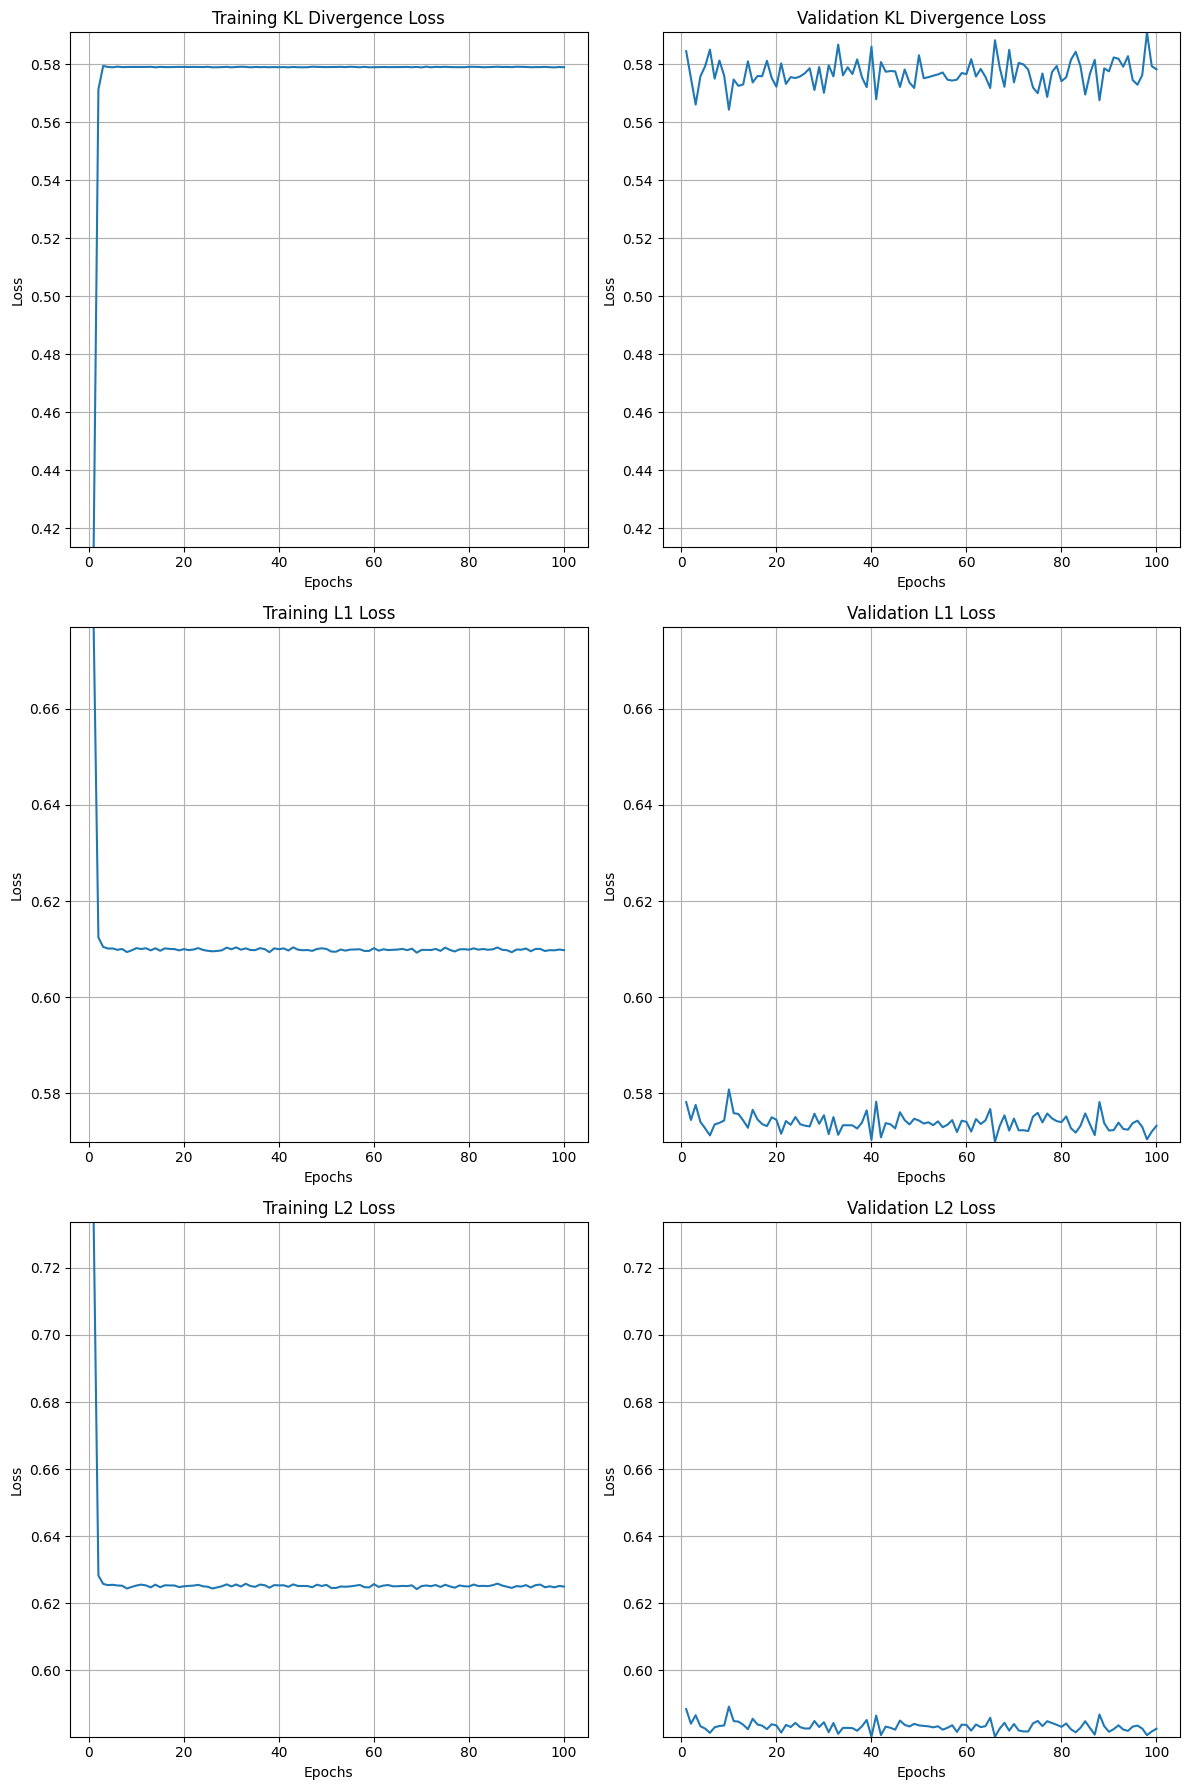

Best Validation Loss in Kelvins:
55.1661 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


z0: 0.0501
z1: -0.0041
z2: 0.0160
z3: -0.0158


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 672.04it/s]


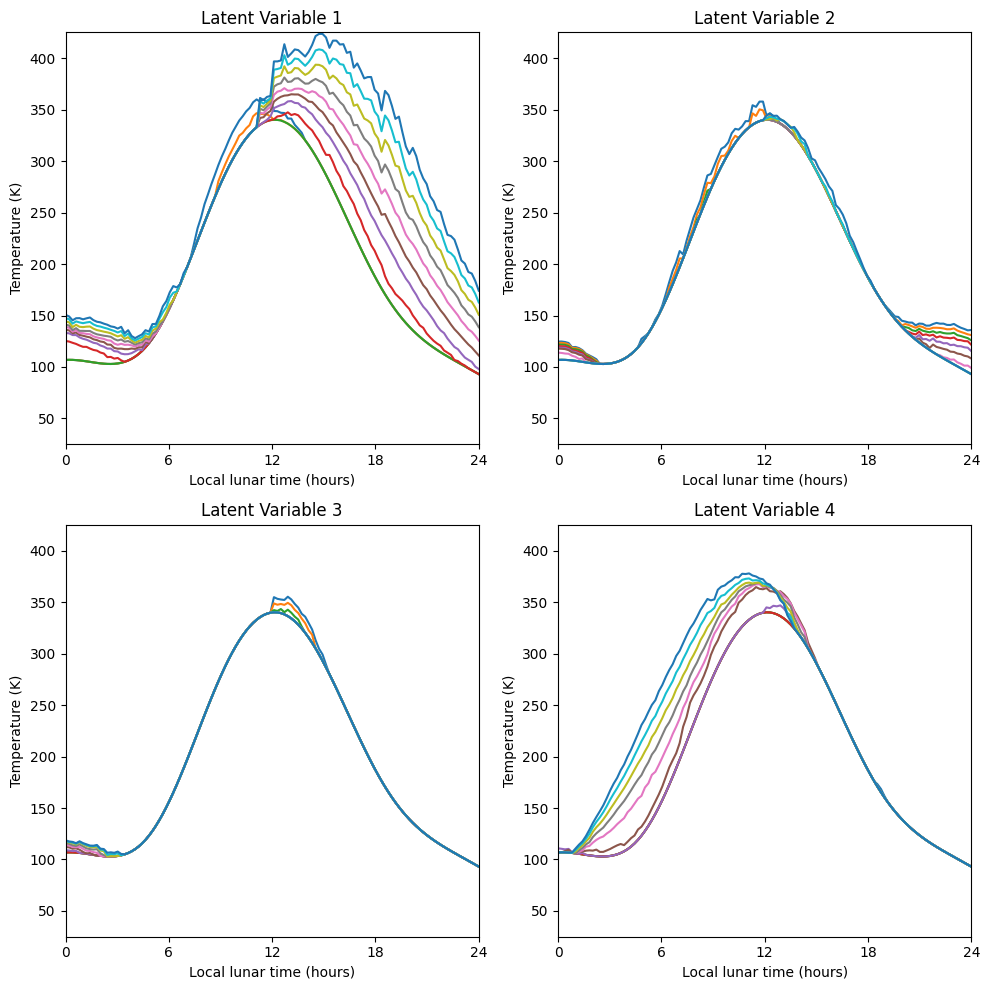

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)